In [1]:
import matplotlib.pyplot as plt
import torch

from src import read_dicom, Detector, Siddon

device = torch.device("cuda:0")
# device = torch.device("cpu")

In [2]:
# Make a random detector
source = [180., 180., -400.]
center = [180., 180., 600.]

detector = Detector(
    source=source,
    center=center,
    height=101,
    width=101,
    delx=4.,
    dely=4.,
    device=device
)

source = detector.source
rays = detector.make_xrays()

In [3]:
# Read in the volume
volume, spacing = read_dicom("../data/cxr/")

# Get alphamin and alpha max
isocenter = [0., 0., 0.]
siddon = Siddon(spacing, isocenter, volume, device)
alphamin, alphamax = siddon.get_alpha_minmax(source, rays)

# Get CT size and spacing parameters
nx, ny, nz = siddon.volume.shape
dx, dy, dz = siddon.spacing

# Get the alpha at each plane
sx, sy, sz = detector.source
alphax = torch.arange(nx, dtype=torch.float32, device=device) * dx + sx
alphay = torch.arange(ny, dtype=torch.float32, device=device) * dy + sy
alphaz = torch.arange(nz, dtype=torch.float32, device=device) * dz + sz

target = rays - source
alphax = alphax.unsqueeze(-1).unsqueeze(-1) / target[:, :, 0]
alphay = alphay.unsqueeze(-1).unsqueeze(-1) / target[:, :, 1]
alphaz = alphaz.unsqueeze(-1).unsqueeze(-1) / target[:, :, 2]

In [4]:
# Combine all alphas and get those in [alphamin, alphamax]
alphas = torch.vstack([alphax, alphay, alphaz])
g_idxs = torch.logical_and(alphas >= alphamin, alphas <= alphamax)
alphas[~g_idxs] = torch.nan

# Sorting puts the nans at the end of the list
alphas = alphas.sort(dim=0).values
alphas.shape

torch.Size([1157, 101, 101])

In [5]:
# Get alphamids
alphamid = (alphas[0:-1] + alphas[1:]) / 2
print(alphamid.shape)

torch.Size([1156, 101, 101])


In [6]:
# Get alphamids
alphamid = (alphas[0:-1] + alphas[1:]) / 2
print(alphamid.shape)

# Convert alphamid to voxel index
idxs = ((source + alphamid.unsqueeze(-1) * (target) - siddon.isocenter) / siddon.spacing).trunc()
idxs = (idxs[:, :, :, 0] + idxs[:, :, :, 1] * siddon.volume.shape[1] + idxs[:, :, :, 2] * siddon.volume.shape[2]).long()
idxs[idxs < 0] = 0  # long converts nan to -int, convert back to zero

torch.Size([1156, 101, 101])


In [7]:
# Get voxel value
voxels = torch.take(siddon.volume, idxs)
print(voxels.shape)

# Get the step length
step_length = torch.diff(alphas, dim=0)
print(step_length.shape)

# Get DRR!!!!
drr = torch.nansum(voxels * step_length, dim=0)

torch.Size([1156, 101, 101])
torch.Size([1156, 101, 101])


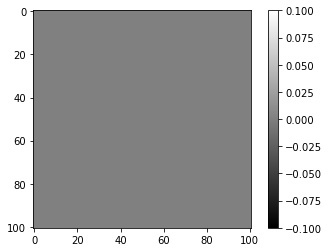

In [8]:
# DRR still looks a little funky
plt.imshow(drr.detach().cpu(), cmap="gray")
plt.colorbar()
plt.show()

In [9]:
# Verify the gradient still works
torch.norm(drr).backward()
source.grad, detector.center.grad

(tensor([nan, nan, nan], device='cuda:0'),
 tensor([nan, nan, nan], device='cuda:0'))

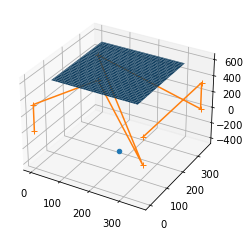

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

source = detector.source.detach().cpu().tolist()
ax.scatter(source[0], source[1], source[2])

corners = rays.detach().cpu()
xs = corners[:, :, 0]
ys = corners[:, :, 1]
zs = corners[:, :, 2]
ax.plot_surface(xs, ys, zs)

ax.plot([0, 0, 0, 360, 0, 360, 360, 360], [0, 0, 360, 0, 360, 360, 360, 0], [0, 332.5, 0, 0, 332.5, 0, 332.5, 332.5], marker="+")

plt.show()